In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# Бутстреп и доверительные интервалы

https://habr.com/ru/company/X5Tech/blog/679842/

Суть метода бутстреп состоит в том, что по имеющейся выборке мы можем построить эмпирическое распределение. Это эмпирическое распределение будет апроксимировать исходное неизвестное нам распределение.

Для того, чтобы узнать значение произвольной статистики, мы можем сгенерировать случайную выборку из распределения. Поскольку настоящее распределение нам неизвестно, то мы заменяем его апроксимацией — указанным ранее эмпирическим распределением. Напомним, что генерация выборки из эмпирического распределения эквивалентна выбору с возвращениями из породившей это эмпирическое распределение выборки. Такой выбор на практике удобно осуществлять с помощью функции [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html):

```
random.choice(a, size=None, replace=True, p=None)
```
При этом мы можем указать размер выборки — произвольный кортеж натуральных чисел. Такой способ гораздо эффективнее, чем последовательно генерировать несколько выборок.

Каждая из порожденных выборок дает точечную оценку для интересующей нас статистики. В целом же многократно сгенерированные выборки дают нам возможность построить распределение интересующей статистики.

## Нахождение распределение статистики с помощью бутстрепа

Сгенерируем выборку из [Гамма распределения](https://en.wikipedia.org/wiki/Gamma_distribution). На её основе можно сформировать множество бутстрепных подвыборок. Наша задача посчитать точечную оценку для коэффициентов данного распределения, а так же на основе бутстрепных оценок построить распределение для этих оценок и указать доверительный интервал. Сравнить всё это с известными значениями коэффициента ассиметрии для гамма распределения.

In [3]:
N = 100
param_a = 3
param_scale = 5
distribution = stats.gamma(a=param_a, scale=param_scale)
x = distribution.rvs(size=N, random_state=23)

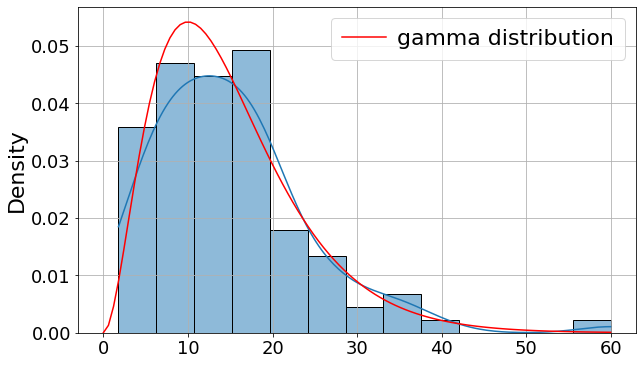

In [4]:
xa = np.linspace(0, max(x), 100)
pdf = distribution.pdf(xa)

sns.histplot(data=x, kde=True, stat='density')
plt.plot(xa, pdf, label='gamma distribution', c='r')
plt.legend()
plt.grid()

Так же можно легко построить эмпирическую функцию распределения и сравнить её с настоящей:

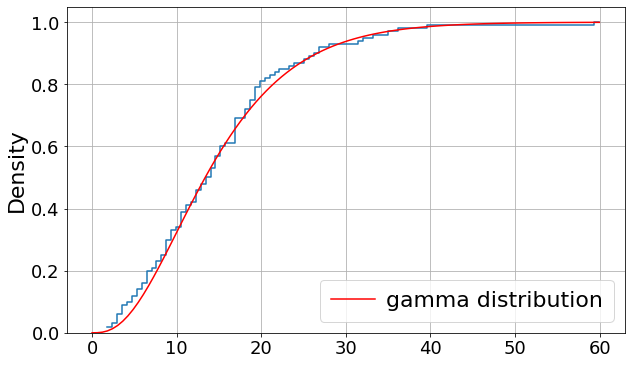

In [5]:
cdf = distribution.cdf(xa)

sns.histplot(
    data=x, cumulative=True, stat='density', 
    fill=False, element='step', bins=100
)

plt.plot(xa, cdf, label='gamma distribution', c='r')
plt.legend()
plt.grid()

## Точечная оценка статистики

Мы можем для нашей выборки получить точечную оценку для $\hat{k}$ и $\hat{\theta}$ (для $a$ и $scale$ соответственно). Напомним, что вычисляются они как
$$
\hat{k} = \frac{N \sum_{i=1}^N X_i}{N \sum_{i=1}^N X_i \ln(X_i) - \sum_{i=1}^N X_i \sum_{i=1}^N \ln(X_i)}
$$

$$
\hat{\theta} = \frac{1}{N^2} \left(N \sum_{i=1}^N X_i \ln(X_i) - \sum_{i=1}^N X_i \sum_{i=1}^N \ln(X_i)\right)
$$

Использование выборочного среднего значения $x$, выборочного среднего значения $\ln{X}$ и выборочного среднего значения произведения $x\ln{X}$ упрощает выражения до:

$$
\hat{k} = \bar{X} / \hat{\theta}
$$

$$
\hat{\theta} = \overline{X\ln{X}} - \bar{X} \overline{\ln{X}}
$$

Хотя эти оценки непротиворечивы, они имеют небольшое смещение. Варианты оценок с поправкой на смещение представлены ниже

$$
\tilde{\theta} = \frac{N}{N - 1} \hat{\theta}
$$
$$
\tilde{k} = \hat{k} - \frac{1}{N} \left(3 \hat{k} - \frac{2}{3} \left(\frac{\hat{k}}{1 + \hat{k}}\right) - \frac{4}{5} \frac{\hat{k}}{(1 + \hat{k})^2} \right)
$$

Мы можем посчитать точечную оценку для нашей выборки и сравнить с известным значением для распределения.

In [6]:
def estimate_scale(x):
    logx = np.log(x)
    scale = np.mean(x * logx) - np.mean(x) * np.mean(logx)
    return len(x) / (len(x) - 1) * scale

def estimate_a(x):
    scale = estimate_scale(x)
    a = np.mean(x) / scale
    return a
    return a - 1 / len(x) * (3 * a - 2/3 * (a / (1 + a) - 4/5 * (a / (1 + a) ** 2)))

In [7]:
print(f'real a = {param_a}, estimated_a = {estimate_a(x)}')
print(f'real scale = {param_scale}, estimated_scale = {estimate_scale(x)}')

real a = 3, estimated_a = 2.634912717258704
real scale = 5, estimated_scale = 5.712751769844184


## Процедура бутстреп и построение доверительных интервалов

С помощью бутстрепа мы можем из имеющейся выборки сгенерировать множество подвыборок. Для каждой из этих подвыборок можно построить точечную оценку и тем самым получить распределение бутстрепных точечных оценок для интересующей нас статистики.

Для таких распределений мы можем построить доверительные интервалы. Например, доверительный интервал на основе процентилей.

In [8]:
alpha = 0.05

B = 1000
real_stat = 5
bs_estimates = []

for _ in range(B):
    bs = np.random.choice(x, size=len(x), replace=True)
    bs_estimate = estimate_a(bs)
    bs_estimates.append(bs_estimate)

bounds = np.quantile(bs_estimates, [alpha / 2, 1 - alpha / 2])
print(bounds)

[1.98292647 3.67102943]


Важно заметить, что при всей мощи бутстрепа он не может преодолеть недостатки конкретной выборки. Если сгенерированная нами выборка не отражает определенных свойств исходного распределения, то бутстрепу дополнительную информацию брать просто неоткуда. В частности даже доверительные интервалы могут не покрыть истинного значения.

In [9]:
N = 1000
alpha = 0.05
B = 1000
# real_stat, estimator = param_a, estimate_a
real_stat, estimator = param_scale, estimate_scale

for _ in range(100):
    distribution = stats.gamma(a=3, scale=5)
    x = distribution.rvs(size=N)
    point_estimate = estimator(x)
    bs_estimates = []

    for _ in range(B):
        bs = np.random.choice(x, size=len(x), replace=True)
        bs_estimate = estimator(bs)
        bs_estimates.append(bs_estimate)

    bounds = np.quantile(bs_estimates, [alpha / 2, 1 - alpha / 2])
    if bounds[0] <= real_stat <= bounds[1]:
        continue

    print(bounds)

[4.00359968 4.85030703]
[3.86961581 4.69116157]


# 3 способа построения доверительных интервалов

In [10]:
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит нормальный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    c = stats.norm.ppf(1 - alpha / 2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right


def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит доверительный интервал на процентилях.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    left, right = np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
    return left, right


def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит центральный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha / 2, 1 - alpha / 2])
    return left, right

Если вы хотите узнать больше о способах построения доверительных интервалов, предлагаем прочитать статью [Бутстреп и А/Б тестирование](https://habr.com/ru/company/X5Tech/blog/679842/) .

# Проверка корректности

In [11]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)


def check_bootstrap(a, b, func=np.mean, B=1000, alpha=0.05):
    """Бутстреп. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    list_diff = func(a_bootstrap, axis=0) - func(b_bootstrap, axis=0)
    left_bound, right_bound = get_ci_bootstrap_percentile(list_diff, None)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res


dict_tests = {
    'ttest': check_ttest,
    'bootstrap': check_bootstrap
}

### Проверим, что тесты работают корректно
Запустим их на выборках из одинаковых распределений, убедимся, что они редко ошибочно находят эффект.

In [12]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})

  0%|          | 0/1000 [00:00<?, ?it/s]

{'ttest': 0.062, 'bootstrap': 0.067}


Теперь будем генерировать выборки из распределений с разными средними, тесты должны начать находить значимые отличия чаще.

In [13]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0.4, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})

  0%|          | 0/1000 [00:00<?, ?it/s]

{'ttest': 0.805, 'bootstrap': 0.815}


### Скорость работы
Видим, что вычисления занимают некоторое время. Сравним скорость вычисления тестов в зависимости от размера выборки.

In [14]:
test_times = {test_name: [] for test_name in dict_tests}
sample_sizes = np.logspace(2, 5, 20).astype(int)

for sample_size in tqdm(sample_sizes):
    a = np.random.normal(0, 1, sample_size)
    b = np.random.normal(0, 1, sample_size)
    for test_name, test in dict_tests.items():
        t1 = time.time()
        test(a, b)
        t2 = time.time()
        test_times[test_name].append(t2 - t1)

  0%|          | 0/20 [00:00<?, ?it/s]

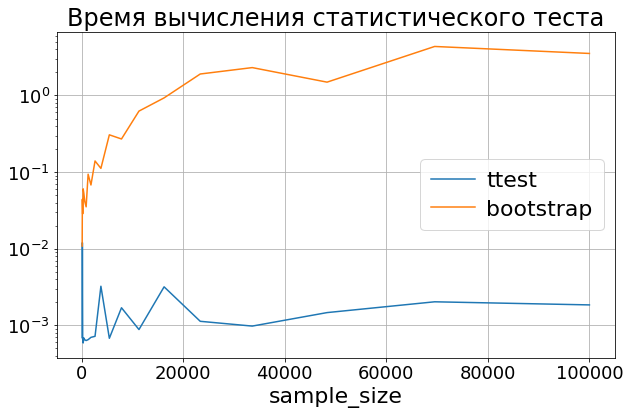

In [15]:
for test_name, times in test_times.items():
    plt.plot(sample_sizes, times, label=test_name)
plt.title('Время вычисления статистического теста')
plt.grid()
plt.xlabel('sample_size')
plt.yscale('log')
plt.legend()
plt.show()

Видно, что ttest отрабатывает значительно быстрее. Время работы теста бутстрепа заметно растет при увеличении объёма данных.

Заметим, что бутстреп на несколько порядков медленнее. Он полезен для построения доверительных интервалов оценок, но для проверки гипотез о равенстве средних на больших данных его лучше не использовать из-за скорости работы.



# Зависимость от размера выборки

In [16]:
np.random.seed(23)

N = 5000
alpha = 0.05
B = 1000
# real_stat, estimator = param_a, estimate_a
real_stat, estimator = param_scale, estimate_scale


distribution = stats.gamma(a=3, scale=5)
all_data = distribution.rvs(size=N)

point_estimates = []
bounds_list = []
sizes = np.linspace(50, N+1, 50).astype(np.int32)

for size in sizes:
    x = all_data[:size]
    point_estimate = estimator(x)
    point_estimates.append(point_estimate)

    bs_estimates = []
    for _ in range(B):
        bs = np.random.choice(x, size=len(x), replace=True)
        bs_estimate = estimator(bs)
        bs_estimates.append(bs_estimate)

    bounds = np.quantile(bs_estimates, [alpha / 2, 1 - alpha / 2])
    bounds_list.append(bounds)

bounds_list = np.array(bounds_list)

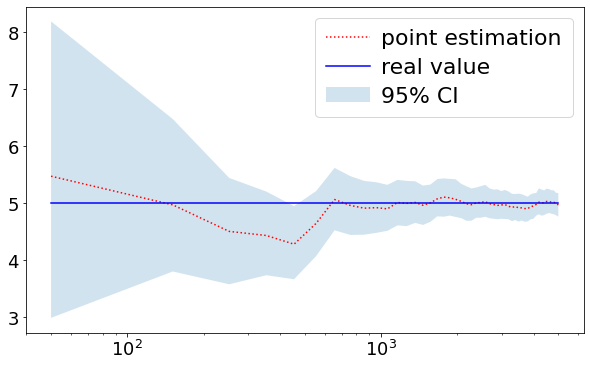

In [17]:
plt.xscale('log')
plt.fill_between(sizes, bounds_list[:, 0], bounds_list[:, 1], alpha=0.2, label=f'{int(100 - alpha*100)}% CI')
plt.plot(sizes, point_estimates, ':r', label=f'point estimation')
plt.plot(sizes, [real_stat] * len(sizes), 'b', label=f'real value')
plt.legend()

Обратите внимание, что ось $Ox$ логарифмическая. С ростом размера **выборки** (не с ростом размера бутстрепных итераций) обычно доверительный интервал сужается

# Данные пиццерии

In [18]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [19]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


web-logs — таблица с логами посещения сайта.

1. user_id — идентификатор пользователя;
2. page — какая страница сайта была открыта. Типы страниц:
    + m — страница с меню;
    + b  — страница с корзиной и подтверждением заказа;
    + p — страница с оплатой заказа;
3. date — дата открытия страницы;
4. load_time — время загрузки страницы в миллисекундах.

**Предполагается, что данные независимы**

In [20]:
np.random.seed(23)

web_logs_hist = web_logs
users = web_logs_hist['user_id'].unique()

np.random.shuffle(users)
group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
load_time_a = web_logs_hist[web_logs_hist['user_id'].isin(group_a)]['load_time'].values
load_time_b = web_logs_hist[web_logs_hist['user_id'].isin(group_b)]['load_time'].values

Нашей целью будет построить $95\%$ доверительный интервал для разницы $99.9%$ перцентилей.

$$H_0: P_{B; 99.9} = P_{A; 99.9}$$
$$H_1: P_{B; 99.9} \neq P_{A; 99.9}$$

Сначала реализуем функцию, с помощью которой мы можем получить точечную оценку

In [21]:
def get_point_estimate(a_group, b_group, quantile=0.999):
    return np.quantile(b_group, quantile) - np.quantile(a_group, quantile)

Запустим обычную процедуру бутстрепа, но с учетом того, что у нас две выборки. Для этого будем независимо семплировать из групп подвыборки такого же размера и считать бутстрепную оценку. Повторим данную процедуру 1000 раз.

In [22]:
point_estimate = get_point_estimate(load_time_a, load_time_b)
print(point_estimate)

bs_point_estimates = []
for _ in range(1000):
    bs_a = np.random.choice(load_time_a, size=len(load_time_a), replace=True)
    bs_b = np.random.choice(load_time_b, size=len(load_time_b), replace=True)
    bs_point_estimate = get_point_estimate(bs_a, bs_b)
    bs_point_estimates.append(bs_point_estimate)

-108.90149999987307


Построим доверительные интервалы тремя разнымы способами и отобразим из на гистограмме.

In [23]:
normal_ci = get_ci_bootstrap_normal(bs_point_estimates, point_estimate)
percentile_ci = get_ci_bootstrap_percentile(bs_point_estimates, point_estimate)
pivotal_ci = get_ci_bootstrap_pivotal(bs_point_estimates, point_estimate)

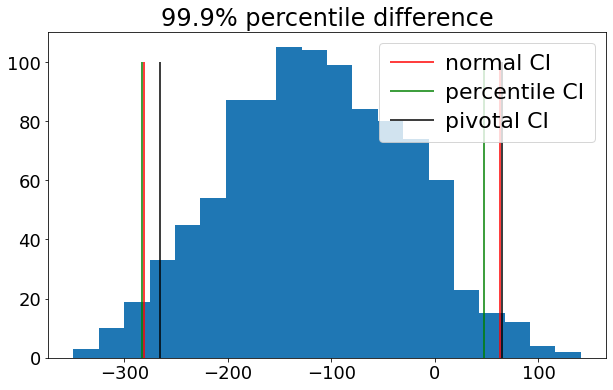

In [24]:
plt.title('99.9% percentile difference')
plt.hist(bs_point_estimates, bins=20);
plt.vlines(normal_ci, 0, 100, label='normal CI', color='red')
plt.vlines(percentile_ci, 0, 100, label='percentile CI', color='green')
plt.vlines(pivotal_ci, 0, 100, label='pivotal CI', color='black')
plt.legend()
plt.show()

**Вывод**: ноль входит внутрь доверительного интервала, а значит мы не можем отвергнуть нулевую гипотезу о том, что 99.9 перцентиль отличается статистически значимо.